In [1]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from sklearn.model_selection import train_test_split

# Paths
img_dir = "/kaggle/input/images/images/images"
label_dir = "/kaggle/input/images/labels/labels"

# List images and labels
img_list = sorted([f for f in os.listdir(img_dir) if f.endswith(".tif")])
label_list = sorted([f for f in os.listdir(label_dir) if f.endswith(".png")])

# Keep only matching pairs
img_paths = [os.path.join(img_dir, f) for f in img_list if f.replace(".tif", ".png") in label_list]
label_paths = [os.path.join(label_dir, f.replace(".tif", ".png")) for f in img_list if f.replace(".tif", ".png") in label_list]

# Train-test split
train_img_paths, test_img_paths, train_label_paths, test_label_paths = train_test_split(
    img_paths, label_paths, test_size=0.2, random_state=42
)


LULC Unique Classes: [10. 30. 40. 50. 60. 80.]
Updated Input Image Shape: torch.Size([1, 11, 512, 512])
11


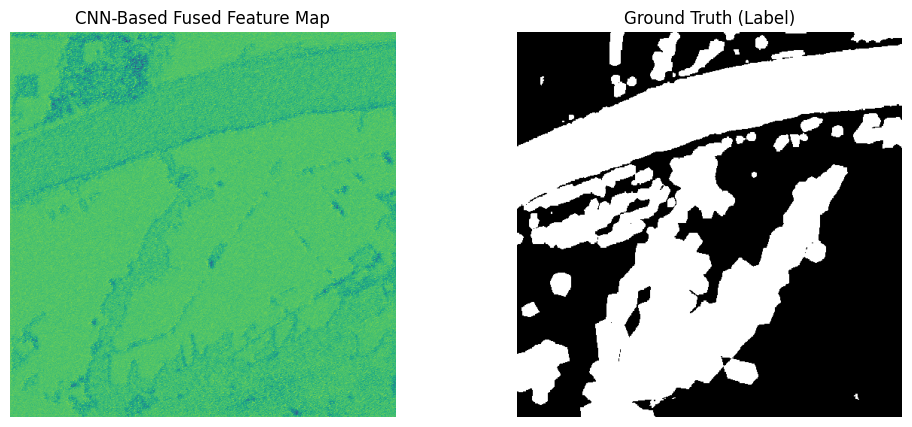

Fused Feature Map Shape: torch.Size([1, 512, 512])
Fused Feature Map Tensor: tensor([[[-0.2756, -0.0834, -0.4196,  ..., -0.3548, -0.3078, -0.2560],
         [ 0.1130, -0.3148, -0.0267,  ..., -0.0213, -0.0247, -0.4987],
         [-0.7098, -0.2026, -0.8798,  ..., -0.6485,  0.0099, -0.2692],
         ...,
         [-0.1374, -0.4296, -0.0193,  ..., -0.2889, -0.4844, -0.1397],
         [-0.0700, -0.4663, -0.1917,  ..., -0.1955,  0.1206, -0.6212],
         [-0.4772, -0.1247, -0.2933,  ..., -0.5369, -0.4554, -0.2947]]],
       grad_fn=<SqueezeBackward1>)
Ground Truth Shape: (512, 512)


In [3]:
import torch
import torch.nn as nn
import tifffile as tiff
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image  # For loading PNG ground truth

# **Step 1: Load the 6-Channel Image**
image_path = "/kaggle/input/images/images/images/3.tif"
label_path = "/kaggle/input/images/labels/labels/3.png"  # Update this path

image = tiff.imread(image_path).astype(np.float32)  # Shape: (H, W, C)
image = np.transpose(image, (2, 0, 1))  # Convert to (C, H, W)
assert image.shape[0] == 6, f"Expected 6 channels, got {image.shape[0]}"

# **Step 2: Load the Ground Truth PNG Label**
label = Image.open(label_path).convert("L")  # Convert to grayscale
label = np.array(label)  # Convert to NumPy array

# **Step 3: Normalize Continuous Channels ([0,1])**
def normalize_channel(channel):
    return (channel - np.min(channel)) / (np.max(channel) - np.min(channel) + 1e-6)

# Normalize all channels except LULC (5th channel)
for i in [0, 1, 2, 3, 5]:  # Skip index 4 (LULC)
    image[i] = normalize_channel(image[i])

# **Step 4: Resize Low-Resolution Channels**
target_size = (image.shape[1], image.shape[2])  # Target resolution (H, W) = 10m
image[3] = cv2.resize(image[3], target_size, interpolation=cv2.INTER_CUBIC)  # DEM 30m
image[5] = cv2.resize(image[5], target_size, interpolation=cv2.INTER_CUBIC)  # Water Occurrence

# **Step 5: One-Hot Encode LULC (Categorical Channel)**
unique_classes = np.unique(image[4])  # Find unique class labels
num_classes = len(unique_classes)
print(f"LULC Unique Classes: {unique_classes}")

# Create empty one-hot encoded array
lulc_one_hot = np.zeros((num_classes, image.shape[1], image.shape[2]))

for i, class_value in enumerate(unique_classes):
    lulc_one_hot[i] = (image[4] == class_value).astype(np.float32)

# **Step 6: Combine Channels for CNN**
# Continuous Channels: [SAR1, SAR2, DEM1, DEM2, Water Occurrence]
continuous_channels = np.array([image[i] for i in [0, 1, 2, 3, 5]])
combined_input = np.concatenate((continuous_channels, lulc_one_hot), axis=0)  # Shape: (C, H, W)

# Convert to PyTorch Tensor
image_tensor = torch.tensor(combined_input, dtype=torch.float32).unsqueeze(0)  # Shape: (1, C, H, W)
print("Updated Input Image Shape:", image_tensor.shape)  # Should be (1, C, H, W)

# **Step 7: Define CNN-Based Fusion Model**
import torch
import torch.nn as nn
import torch.nn.functional as F

class FusionCNN(nn.Module):
    def __init__(self, num_input_channels):
        super(FusionCNN, self).__init__()

        # First block: Extract low-level spatial features
        self.conv1 = nn.Conv2d(in_channels=num_input_channels, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Second block: Extract mid-level features
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)

        # Third block: Extract high-level semantic features
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(16)
        self.conv6 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(16)

        # Final layer: Reduce to 1 feature map
        self.conv_final = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)  

    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)  # Apply dropout

        # Second block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.dropout(x)

        # Third block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout(x)

        # Final output
        x = self.conv_final(x)
        return x.squeeze(0)  # Shape: (1, H, W)

# **Initialize the Model**
num_input_channels = combined_input.shape[0]  
print(num_input_channels)
fusion_model = FusionCNN(num_input_channels)

# **Perform Feature Fusion**
fused_feature_map = fusion_model(image_tensor)

# **Step 9: Visualize Fused Feature Map & Ground Truth**
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# **Plot CNN-Fused Feature Map**
axes[0].imshow(fused_feature_map.detach().numpy().squeeze(), cmap="viridis")
axes[0].set_title("CNN-Based Fused Feature Map")
axes[0].axis("off")

# **Plot Ground Truth Label**
axes[1].imshow(label, cmap="gray")
axes[1].set_title("Ground Truth (Label)")
axes[1].axis("off")

plt.show()

# **Step 10: Print Shape & Tensor**
print("Fused Feature Map Shape:", fused_feature_map.shape)  # Should be (H, W)
print("Fused Feature Map Tensor:", fused_feature_map)
print("Ground Truth Shape:", label.shape)  # Should be (H, W)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import tifffile as tiff
import cv2
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split

class FusionCNN(nn.Module):
    def __init__(self, num_input_channels, base_channels=32, num_blocks=3):
        super(FusionCNN, self).__init__()
        
        self.num_blocks = num_blocks
        self.base_channels = base_channels
        
        self.entry_conv = nn.Conv2d(num_input_channels, base_channels, kernel_size=3, padding=1)
        self.entry_bn = nn.BatchNorm2d(base_channels)
        
        self.feature_blocks = nn.ModuleList()
        current_channels = base_channels
        total_feature_channels = 0
        for i in range(num_blocks):
            out_channels = base_channels * (i + 1)
            block = self._make_block(current_channels, out_channels)
            self.feature_blocks.append(block)
            total_feature_channels += out_channels
            current_channels = out_channels
        
        self.attention = nn.Sequential(
            nn.Conv2d(total_feature_channels, base_channels, kernel_size=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(),
            nn.Conv2d(base_channels, total_feature_channels, kernel_size=1),
            nn.Sigmoid()
        )
        
        self.fusion_conv = nn.Conv2d(total_feature_channels, base_channels, kernel_size=3, padding=1)
        self.layer_norm = nn.LayerNorm([base_channels, 512, 512])  # Adjust for your image size
        self.final_conv = nn.Conv2d(base_channels, 1, kernel_size=3, padding=1)
        
        self.dropout = nn.Dropout2d(0.3)
    
    def _make_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, dilation=2, padding=2),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        x = F.relu(self.entry_bn(self.entry_conv(x)))
        
        block_outputs = []
        current = x
        for block in self.feature_blocks:
            current = block(current)
            block_outputs.append(current)
        
        features = torch.cat(block_outputs, dim=1)
        attention_weights = self.attention(features)
        attended_features = features * attention_weights
        
        x = F.relu(self.fusion_conv(attended_features))
        x = self.dropout(x)
        
        x = self.layer_norm(x)  # Apply LayerNorm here when channels = base_channels
        x = self.final_conv(x)
        
        return x.squeeze(1)  # [batch_size, H, W]

class FusionDataset(Dataset):
    def __init__(self, img_paths, label_paths, fusion_model, num_lulc_classes, device):
        self.img_paths = img_paths
        self.label_paths = label_paths
        self.fusion_model = fusion_model.eval()
        self.num_lulc_classes = num_lulc_classes
        self.device = device

    def normalize_channel(self, channel):
        return (channel - np.min(channel)) / (np.max(channel) - np.min(channel) + 1e-6)

    def __getitem__(self, idx):
        img = tiff.imread(self.img_paths[idx]).astype(np.float32)
        img = np.transpose(img, (2, 0, 1))

        label = Image.open(self.label_paths[idx]).convert("L")
        label = np.array(label, dtype=np.float32)

        for i in [0, 1, 2, 3, 5]:
            img[i] = self.normalize_channel(img[i])

        target_size = (img.shape[1], img.shape[2])
        img[3] = cv2.resize(img[3], target_size, interpolation=cv2.INTER_CUBIC)
        img[5] = cv2.resize(img[5], target_size, interpolation=cv2.INTER_CUBIC)

        lulc_one_hot = np.zeros((self.num_lulc_classes, img.shape[1], img.shape[2]))
        for class_value in range(self.num_lulc_classes):
            lulc_one_hot[class_value] = (img[4] == class_value).astype(np.float32)

        continuous_channels = np.array([img[i] for i in [0, 1, 2, 3, 5]])
        combined_input = np.concatenate((continuous_channels, lulc_one_hot), axis=0)

        img_tensor = torch.tensor(combined_input, dtype=torch.float32).unsqueeze(0).to(self.device)

        with torch.no_grad():
            fused_feature_map = self.fusion_model(img_tensor)

        label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(0).to(self.device)

        return fused_feature_map, label_tensor

    def __len__(self):
        return len(self.img_paths)

# Main execution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

img_dir = "/kaggle/input/images/images/images"
label_dir = "/kaggle/input/images/labels/labels"

img_list = sorted([f for f in os.listdir(img_dir) if f.endswith(".tif")])
label_list = sorted([f for f in os.listdir(label_dir) if f.endswith(".png")])

img_paths = [os.path.join(img_dir, f) for f in img_list if f.replace(".tif", ".png") in label_list]
label_paths = [os.path.join(label_dir, f.replace(".tif", ".png")) for f in img_list if f.replace(".tif", ".png") in label_list]

train_img_paths, test_img_paths, train_label_paths, test_label_paths = train_test_split(
    img_paths, label_paths, test_size=0.2, random_state=42
)

lulc_img = tiff.imread(train_img_paths[0])[4]
num_lulc_classes = len(np.unique(lulc_img))

num_input_channels = 5 + num_lulc_classes
fusion_model = FusionCNN(num_input_channels=num_input_channels, base_channels=32, num_blocks=3).to(device)

train_dataset = FusionDataset(train_img_paths, train_label_paths, fusion_model, num_lulc_classes, device)
test_dataset = FusionDataset(test_img_paths, test_label_paths, fusion_model, num_lulc_classes, device)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Fetch one batch
fused_features, labels = next(iter(train_loader))
print("Fused Feature Map Shape:", fused_features.shape)
print("Label Shape:", labels.shape)

Using device: cuda
Fused Feature Map Shape: torch.Size([4, 1, 512, 512])
Label Shape: torch.Size([4, 1, 512, 512])


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.up(x)

class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()
        self.w_g = nn.Sequential(
            nn.Conv2d(f_g, f_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(f_int)
        )
        self.w_x = nn.Sequential(
            nn.Conv2d(f_l, f_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(f_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(f_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__() 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = ConvBlock(ch_in=in_channels, ch_out=64)  # Updated to 11 channels
        self.conv2 = ConvBlock(ch_in=64, ch_out=128)
        self.conv3 = ConvBlock(ch_in=128, ch_out=256)
        self.conv4 = ConvBlock(ch_in=256, ch_out=512)
        self.conv5 = ConvBlock(ch_in=512, ch_out=1024)
        
        self.up5 = UpConvBlock(ch_in=1024, ch_out=512)
        self.att5 = AttentionBlock(f_g=512, f_l=512, f_int=256)
        self.upconv5 = ConvBlock(ch_in=1024, ch_out=512)
        
        self.up4 = UpConvBlock(ch_in=512, ch_out=256)
        self.att4 = AttentionBlock(f_g=256, f_l=256, f_int=128)
        self.upconv4 = ConvBlock(ch_in=512, ch_out=256)
        
        self.up3 = UpConvBlock(ch_in=256, ch_out=128)
        self.att3 = AttentionBlock(f_g=128, f_l=128, f_int=64)
        self.upconv3 = ConvBlock(ch_in=256, ch_out=128)
        
        self.up2 = UpConvBlock(ch_in=128, ch_out=64)
        self.att2 = AttentionBlock(f_g=64, f_l=64, f_int=32)
        self.upconv2 = ConvBlock(ch_in=128, ch_out=64)
        
        self.conv_1x1 = nn.Conv2d(64, out_channels, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        if x.dim() == 5:  # Check if input has extra dimension
            x = x.squeeze(2)
        # Encoder
        x1 = self.conv1(x)
        x2 = self.conv2(self.maxpool(x1))
        x3 = self.conv3(self.maxpool(x2))
        x4 = self.conv4(self.maxpool(x3))
        x5 = self.conv5(self.maxpool(x4))
        
        # Decoder + Attention
        d5 = self.upconv5(torch.cat((self.att5(self.up5(x5), x4), self.up5(x5)), dim=1))
        d4 = self.upconv4(torch.cat((self.att4(self.up4(d5), x3), self.up4(d5)), dim=1))
        d3 = self.upconv3(torch.cat((self.att3(self.up3(d4), x2), self.up3(d4)), dim=1))
        d2 = self.upconv2(torch.cat((self.att2(self.up2(d3), x1), self.up2(d3)), dim=1))
        
        d1 = self.conv_1x1(d2)
        
        return torch.sigmoid(d1)  # Output probability map

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scaler = torch.cuda.amp.GradScaler()

# Define Dice Loss Function
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1.0):
        inputs = torch.sigmoid(inputs)  # Apply sigmoid
        intersection = (inputs * targets).sum(dim=[1, 2, 3])
        dice = (2. * intersection + smooth) / (inputs.sum(dim=[1, 2, 3]) + targets.sum(dim=[1, 2, 3]) + smooth)
        return 1 - dice.mean()

# Define Dice Coefficient Metric
def dice_coef_metric(inputs, targets):
    intersection = 2.0 * (inputs * targets).sum(dim=[1, 2, 3])
    union = inputs.sum(dim=[1, 2, 3]) + targets.sum(dim=[1, 2, 3])
    dice = intersection / (union + 1e-7)
    return dice.mean()

# Optimized Training Function
def train_model(model_name, model, train_loader, val_loader, train_loss_fn, optimizer, lr_scheduler=None, num_epochs=50):
    print(f"\n[INFO] Training Model: {model_name}")
    
    loss_history, train_history, val_history = [], [], []
    bce_loss_fn = nn.BCEWithLogitsLoss().to(device)  # Move loss function to GPU
    
    model.train()
    
    for epoch in range(num_epochs):
        epoch_losses = []
        epoch_dices = []
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        
        for data, target in progress_bar:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            
            with torch.amp.autocast('cuda'):  # Mixed Precision for faster computation
                outputs = model(data)
                bce_loss = bce_loss_fn(outputs, target)
                dice_loss = train_loss_fn(outputs, target)
                loss = bce_loss + dice_loss
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Compute Dice Coefficient (Threshold = 0.5)
            out_cut = (torch.sigmoid(outputs) > 0.5).float()
            train_dice = dice_coef_metric(out_cut, target)
            
            epoch_losses.append(loss.detach())  # Use detach() instead of .item() for efficiency
            epoch_dices.append(train_dice.detach())

            progress_bar.set_postfix({"Loss": loss.item(), "Dice": train_dice.item()})

        if lr_scheduler:
            lr_scheduler.step()
        
        # Compute Validation Dice Score
        val_dice = compute_iou(model, val_loader)
        
        loss_history.append(torch.mean(torch.stack(epoch_losses)).cpu().numpy())
        train_history.append(torch.mean(torch.stack(epoch_dices)).cpu().numpy())
        val_history.append(val_dice)

        print(f"Epoch [{epoch+1}/{num_epochs}] -> Train Loss: {loss_history[-1]:.4f}, Train Dice: {train_history[-1]:.4f}, Val Dice: {val_dice:.4f}")

    return loss_history, train_history, val_history

# Optimized Validation Function
@torch.no_grad()
def compute_iou(model, loader, threshold=0.5):
    model.eval()
    total_iou, count = 0, 0
    
    for data, target in loader:
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        with torch.amp.autocast('cuda'):  # Use mixed precision
            outputs = model(data)
            out_cut = (torch.sigmoid(outputs) > threshold).float()
        
        total_iou += dice_coef_metric(out_cut, target).detach()
        count += 1

    return (total_iou / count).cpu().numpy() if count > 0 else 0

# Model Initialization
attention_unet = AttentionUNet(in_channels=1, out_channels=1).to(device)
optimizer = torch.optim.Adamax(attention_unet.parameters(), lr=1e-3)

num_epochs = 5
aun_lh, aun_th, aun_vh = train_model("Attention UNet", attention_unet, train_loader, test_loader, DiceLoss(), optimizer, None, num_epochs)

<ipython-input-27-950282361c09>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



[INFO] Training Model: Attention UNet


Epoch [1/5] -> Train Loss: 1.6201, Train Dice: 0.0166, Val Dice: 0.0002


Epoch [2/5] -> Train Loss: 1.6128, Train Dice: 0.0001, Val Dice: 0.0000


Epoch [3/5] -> Train Loss: 1.6128, Train Dice: 0.0000, Val Dice: 0.0000


Epoch [4/5] -> Train Loss: 1.6128, Train Dice: 0.0000, Val Dice: 0.0000


KeyboardInterrupt: 

In [ ]:
torch.save(attention_unet.state_dict(), "flood_segmentation_model.pth")
print("Model saved successfully!")

In [ ]:
model = AttentionUNet(1, 1)  # Use the correct model class
model.load_state_dict(torch.load("flood_segmentation_model.pth"))
model.to(device)
model.eval()  # Set to evaluation mode

In [ ]:

# ----------------------- Compute Training Accuracy -----------------------
train_correct = 0
train_total = 0

model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        pred_masks = (outputs.sigmoid() > 0.52).float()

        train_correct += (pred_masks == labels).sum().item()
        train_total += labels.numel()

train_accuracy = train_correct / train_total
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

# ---------------------- Evaluate Model on Test Data ----------------------
test_preds = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        pred_masks = (outputs.sigmoid() > 0.52).cpu().numpy().astype(np.uint8)
        labels = labels.cpu().numpy().astype(np.uint8)

        test_preds.extend(pred_masks.flatten())
        test_labels.extend(labels.flatten())

# Compute Accuracy & F1 Score
test_accuracy = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test F1 Score: {test_f1:.4f}")

In [ ]:
import tifffile as tiff
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------ IMAGE PROCESSING ------------------

# Load 6-channel TIF image
image_path = "/kaggle/input/images/images/images/1.tif"
label_path = "/kaggle/input/images/labels/labels/1.png"  # Ground truth

image = tiff.imread(image_path).astype(np.float32)  # Shape: (H, W, C)
image = np.transpose(image, (2, 0, 1))  # Convert to (C, H, W)
assert image.shape[0] == 6, f"Expected 6 channels, got {image.shape[0]}"

# Load and preprocess ground truth label
label = Image.open(label_path).convert("L")  # Convert to grayscale
label = np.array(label)  # Convert to NumPy array

# Normalize Continuous Channels ([0,1])
def normalize_channel(channel):
    return (channel - np.min(channel)) / (np.max(channel) - np.min(channel) + 1e-6)

# Normalize all channels except LULC (5th channel)
for i in [0, 1, 2, 3, 5]:  # Skip index 4 (LULC)
    image[i] = normalize_channel(image[i])

# Resize Low-Resolution Channels (DEM, Water Occurrence)
target_size = (image.shape[1], image.shape[2])  # (H, W)
image[3] = cv2.resize(image[3], target_size, interpolation=cv2.INTER_CUBIC)  # DEM 30m
image[5] = cv2.resize(image[5], target_size, interpolation=cv2.INTER_CUBIC)  # Water Occurrence

# One-Hot Encode LULC (Categorical Channel)
unique_classes = np.unique(image[4])  # Find unique class labels
num_classes = len(unique_classes)
print(f"LULC Unique Classes: {unique_classes}")

# Create empty one-hot encoded array
lulc_one_hot = np.zeros((num_classes, image.shape[1], image.shape[2]))

for i, class_value in enumerate(unique_classes):
    lulc_one_hot[i] = (image[4] == class_value).astype(np.float32)

# Combine Continuous and One-Hot Encoded Channels
continuous_channels = np.array([image[i] for i in [0, 1, 2, 3, 5]])  # Select continuous channels
combined_input = np.concatenate((continuous_channels, lulc_one_hot), axis=0)  # Shape: (C, H, W)

# Convert to PyTorch Tensor
image_tensor = torch.tensor(combined_input, dtype=torch.float32).unsqueeze(0).to(device)  # (1, C, H, W)
print("Updated Input Image Shape:", image_tensor.shape)  # Should be (1, C, H, W)

# ------------------ MODEL INFERENCE ------------------

# Initialize the models
num_input_channels = combined_input.shape[0]  # Final input channels
print(f"Input Channels for FusionCNN: {num_input_channels}")

fusion_model = FusionCNN(num_input_channels).to(device)
attention_unet = AttentionUNet().to(device)

# Pass through FusionCNN
with torch.no_grad():
    fused_feature_map = fusion_model(image_tensor)

# Pass through Attention UNet
with torch.no_grad():
    flood_pred = attention_unet(fused_feature_map)

# Convert output to binary mask
pred_mask = flood_pred.cpu().numpy().squeeze()
pred_mask = (pred_mask > 0.53).astype(np.uint8)

# Normalize ground truth label
gt_mask = (label > 0).astype(np.uint8)

# Compute Accuracy and F1 Score
accuracy = accuracy_score(gt_mask.flatten(), pred_mask.flatten())
f1 = f1_score(gt_mask.flatten(), pred_mask.flatten(), average="macro")

# ------------------ VISUALIZATION ------------------

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(gt_mask, cmap="gray")
ax[0].set_title("Ground Truth")
ax[0].axis("off")

ax[1].imshow(pred_mask, cmap="gray")
ax[1].set_title("Predicted Flood Map")
ax[1].axis("off")

plt.show()

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
